###Import libraries

In [11]:
try:
  import yfinance as yf
except:
  # install a library
  !pip install yfinance --upgrade --no-cache-dir 
  import yfinance as yf

In [12]:
try:
  import yahoo_fin
  from yahoo_fin import stock_info as si
except:
  # install a library
  !pip install yahoo_fin 
  import yahoo_fin
  from yahoo_fin import stock_info as si

In [13]:
# Base Libraries
import pandas as pd
import numpy as np

# Graphs
%matplotlib inline
import matplotlib.pyplot as plt
width, height = 15, 6 
plt.rcParams['figure.figsize'] = [width, height]
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score

# SVM
from sklearn.svm import SVR, SVC, NuSVC

# Metrics
## Classification metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

##2. Data Collection

###US Stock Exchanges' list of tickers

In [14]:
# table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# SP_companies = table[0]

# SP_tickers = SP_companies['Symbol']

# SP_companies.head()

#df_companies.to_csv('S&P500-Info.csv')
#df_companies.to_csv("S&P500-Symbols.csv", columns=['Symbol'])

In [15]:
def getUsefulSymbolsSet(symbols):
  # Some stocks are 5 characters. Those stocks with the suffixes listed below are not of interest.
  suffix_notToUse = ['W', 'R', 'P', 'Q']
  del_set = set()
  sav_set = set()

  for symbol in symbols:
      if len( symbol ) > 4 and symbol[-1] in suffix_notToUse:
          del_set.add( symbol )
      else:
          sav_set.add( symbol )

  print( f'Removed {len( del_set )} unqualified stock symbols...' )
  print( f'There are {len( sav_set )} qualified stock symbols...' )

  return sav_set, del_set

In [16]:
# gather stock symbols from major US exchanges
df_SP = pd.DataFrame( si.tickers_sp500() )
df_NDQ = pd.DataFrame( si.tickers_nasdaq() )
df_DOW = pd.DataFrame( si.tickers_dow() )
df_Others = pd.DataFrame( si.tickers_other() )

# convert DataFrame to list, then to sets
sym_SP = set( symbol for symbol in df_SP[0].values.tolist() )
sym_NDQ = set( symbol for symbol in df_NDQ[0].values.tolist() )
sym_DOW = set( symbol for symbol in df_DOW[0].values.tolist() )
sym_Others = set( symbol for symbol in df_Others[0].values.tolist() )

# join the 4 sets into one. Because it's a set, there will be no duplicate symbols
symbols = set.union( sym_SP, sym_NDQ, sym_DOW, sym_Others )

sav_Symbols, del_Symbols = getUsefulSymbolsSet( symbols )

Removed 1101 unqualified stock symbols...
There are 11016 qualified stock symbols...


###Read data

In [17]:
def getHistoricalTickerData(ticker, start, end):
  # Fetch the data by specifying the number of period
  df = yf.download( ticker, #'VOO', 
                    start= start, #'2016-01-01',
                    progress=False,
                    end= end #'2022-10-28' 
                   )

  print('Shape of raw df: ', df.shape)

  # Display the first five rows of the dataframe to check the results. 
  print('First 5 rows in df: ')
  df.head()

  return df

In [18]:
df = pd.read_csv('JPM.csv', parse_dates = True, index_col = 0)

# df['Date'] = pd.to_datetime(df['Date'], yearfirst=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,39.830002,40.360001,39.299999,40.189999,25.692480,12838600
2006-01-04,39.779999,40.139999,39.419998,39.619999,25.544176,13491500
2006-01-05,39.610001,39.810001,39.500000,39.740002,25.621536,8109400
2006-01-06,39.919998,40.240002,39.549999,40.020000,25.802069,7966900
2006-01-09,39.880001,40.720001,39.880001,40.669998,26.221136,16575200


In [19]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [20]:
# jpm = getHistoricalTickerData('JPM', '2006-01-01', '2022-11-01')

###Market Capitalization

In [21]:
# def marketCap(ticker):


In [22]:
# top_5 = df.sort_values(by='Forward Returns', ascending=False).head()
# print('Highest returns: \n')
# top_5

In [23]:
# top_5.plot(y='Forward Returns', kind='bar', rot=5)

##3. Exploratory Data Analysis

###Summary Statistics

In [24]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4241.000000,4241.000000,4241.000000,4241.000000,4241.000000,4.241000e+03
mean,71.944336,72.710259,71.167828,71.943244,60.993454,2.435979e+07
std,36.946053,37.217824,36.679067,36.934392,38.581940,2.062324e+07
min,15.370000,17.290001,14.960000,15.900000,11.343098,2.926400e+06
25%,42.880001,43.400002,42.299999,42.830002,30.139021,1.219680e+07
50%,57.230000,57.709999,56.750000,57.259998,45.327152,1.703780e+07
75%,102.070000,103.230003,100.769997,102.059998,92.526054,2.938780e+07
max,172.710007,172.960007,170.539993,171.779999,166.523987,2.172942e+08


###Linear Correlation

In [25]:
import seaborn as sns
%matplotlib inline

# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
def magnify():
    return [dict(selector="th", props=[("font-size", "7pt")]), dict(selector="td", props=[('padding', "0em 0em")]), dict(selector="th:hover", props=[("font-size", "12pt")]), dict(selector="tr:hover td:hover", props=[('max-width', '200px'), ('font-size', '12pt')])  ]

corr.style.background_gradient(cmap, axis=1).set_properties(**{'max-width': '80px', 'font-size': '10pt'}).set_caption("Hover to magify").set_precision(2).set_table_styles(magnify())

,Open,High,Low,Close,Adj Close,Volume
Open,1.00,1.00,1.00,1.00,1.00,-0.46
High,1.00,1.00,1.00,1.00,1.00,-0.45
Low,1.00,1.00,1.00,1.00,1.00,-0.46
Close,1.00,1.00,1.00,1.00,1.00,-0.46
Adj Close,1.00,1.00,1.00,1.00,1.00,-0.43
Volume,-0.46,-0.45,-0.46,-0.46,-0.43,1.00


###Time Series Visualization

In [51]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'O-C', 'C-C',
       'O-O', 'H-L', 'Lagged 1', 'Lagged 2', 'Lagged 3', 'Lagged 4',
       'Lagged 5', 'Lagged 6', 'Momentum 6', 'Momentum 30', 'SMA', 'EMA',
       'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct',
       'nov', 'dec', 'Sign'],
      dtype='object')

In [ ]:
import plotly.express as px 

In [54]:
fig = px.line(df, y=['Open', 'High', 'Low', 'Adj Close'])
fig.show()

In [53]:
fig = px.line(df, y=['Volume'])
fig.show()

In [55]:
fig = px.line(df, y=['Close'])
fig.show()

In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=3)
# df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].plot(subplots=True, ax=axes)

In [ ]:
# df['Close'].plot()

###Seasonality


In [56]:
import statsmodels.api as sm

def plotSeasonality(freq):
  if freq == None:
    freq = 'd'
  analysis = df['Close'].asfreq(freq).fillna(method='bfill').fillna(method='ffill')
  decompose_result = sm.tsa.seasonal_decompose(analysis, model='additive')
  fig = decompose_result.plot()

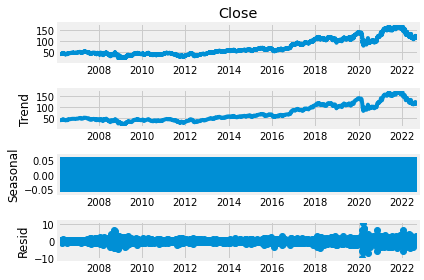

In [57]:
plotSeasonality('d')

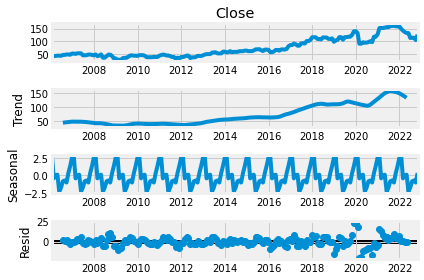

In [31]:
plotSeasonality('m')

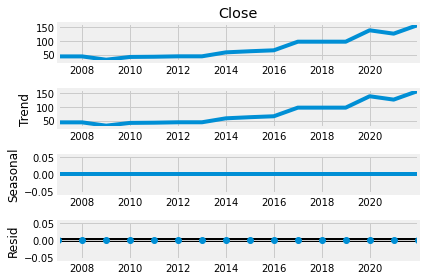

In [32]:
plotSeasonality('y')

##4. Data Cleaning

###Data Types

All time series in the data are of type float, and no categorical data that may need to be encoded is present, at this point in our analysis.

In [33]:
# data types

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4241 entries, 2006-01-03 to 2022-11-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4241 non-null   float64
 1   High       4241 non-null   float64
 2   Low        4241 non-null   float64
 3   Close      4241 non-null   float64
 4   Adj Close  4241 non-null   float64
 5   Volume     4241 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 361.0 KB


###Missing Data

We see that the data does not have any missing values which need to be handled, at this point in our analysis.

In [34]:
# missing data

df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

###Outliers

We make the design choice to not remove outliers, since this is univariate time series prediction and we want to retain as much unique information as available.

In [35]:
top_5 = df.sort_values(by='Close', ascending=False).head()
print('Highest returns: \n')
top_5

Highest returns: 



,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-22,170.029999,172.089996,169.699997,171.779999,166.523987,8817900
2021-10-26,171.000000,172.490005,170.539993,171.399994,166.155594,8015100
2021-10-25,172.710007,172.960007,170.479996,170.940002,165.709671,10159200
2021-10-20,168.300003,170.869995,167.460007,170.839996,165.612732,8185600
2021-11-03,170.130005,171.130005,169.149994,170.529999,165.312241,8402700


In [36]:
bottom_5 = df.sort_values(by='Close', ascending=True).head()
print('Lowest returns: \n')
top_5

Lowest returns: 



,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-22,170.029999,172.089996,169.699997,171.779999,166.523987,8817900
2021-10-26,171.000000,172.490005,170.539993,171.399994,166.155594,8015100
2021-10-25,172.710007,172.960007,170.479996,170.940002,165.709671,10159200
2021-10-20,168.300003,170.869995,167.460007,170.839996,165.612732,8185600
2021-11-03,170.130005,171.130005,169.149994,170.529999,165.312241,8402700


In [37]:
# df with these outliers in March 2020 dropped
# df_clean = df[ ~df[ (df.index.year == 2020) & (df.index.month == 3) ] ]

##5. Transformation

###Feature Engineering

We first create a few typically used features for algorithmic asset returns trend prediction.

In [38]:
target_feature = 'Close'

In [39]:
df['O-C'] = df['Open'] - df['Close']
df['C-C'] = df['Low'].diff().shift(-1) 
df['O-O'] = df['Open'].diff().shift(-1) 
df['H-L'] = df['High'] - df['Low'] # does the trend depend on vol? not really

# Lagged returns may matter, since best predictor of a univariate time series is its own past behaviour. Note that no seasonal behaviour is observed
def laggedTimeSeries( lag = 6, target_feature = target_feature ):
  for i in range(1,lag+1):
    df[str('Lagged '+str(i))] =  df[target_feature].shift(-i)  
laggedTimeSeries( lag = 6, target_feature = target_feature )

# Momentum may matter, though no seasonal behaviour is observed. Indicate whether long MA is above short MA
df['Momentum 6'] =  df[target_feature].diff().shift(-6)  
df['Momentum 30'] =  df[target_feature].diff().shift(-30)  

# Moving Averages
df['SMA'] = df[target_feature].rolling(30).mean()  # Should ideally pick one out of SMA and EMA

alpha = 2/( df[target_feature].count() + 1)
df['EMA'] = df[target_feature].ewm(alpha=alpha).mean()# Kind of a wted avg, more wt to near past, less wt to far past

In [40]:
# Seasonality indicators - one hot encoding, representing each month
df3 = pd.get_dummies(df.index.month) 
df3.columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df3['Date'] = df.index
df3.set_index('Date', inplace=True)

df2 = pd.concat( [ df, df3 ], axis=1)
df = df2

In [41]:
# Sign of 1-day prior Close price daily log returns
df['Sign'] = np.sign(np.log(df[target_feature]).diff().shift(-1).shift(-1))

In [42]:
df.shape

(4241, 33)

In [44]:
# Removing any null values
df.dropna(inplace=True)

In [43]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,O-C,C-C,O-O,H-L,...,apr,may,jun,jul,aug,sep,oct,nov,dec,Sign
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,39.830002,40.360001,39.299999,40.189999,25.692480,12838600,-0.359997,0.119999,-0.050003,1.060002,...,0,0,0,0,0,0,0,0,0,1.0
2006-01-04,39.779999,40.139999,39.419998,39.619999,25.544176,13491500,0.160000,0.080002,-0.169998,0.720001,...,0,0,0,0,0,0,0,0,0,1.0
2006-01-05,39.610001,39.810001,39.500000,39.740002,25.621536,8109400,-0.130001,0.049999,0.309997,0.310001,...,0,0,0,0,0,0,0,0,0,1.0
2006-01-06,39.919998,40.240002,39.549999,40.020000,25.802069,7966900,-0.100002,0.330002,-0.039997,0.690003,...,0,0,0,0,0,0,0,0,0,1.0
2006-01-09,39.880001,40.720001,39.880001,40.669998,26.221136,16575200,-0.789997,0.189999,0.619999,0.840000,...,0,0,0,0,0,0,0,0,0,-1.0


####Visualization

In [58]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'O-C', 'C-C',
       'O-O', 'H-L', 'Lagged 1', 'Lagged 2', 'Lagged 3', 'Lagged 4',
       'Lagged 5', 'Lagged 6', 'Momentum 6', 'Momentum 30', 'SMA', 'EMA',
       'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct',
       'nov', 'dec', 'Sign'],
      dtype='object')

In [ ]:
# fig = px.line(df, y=['Close'])

# fill_data = df[df['Sign'] >= 1]
# for idx,row in fill_data.iterrows():
#     d = str(row.index)
#     fig.add_vrect(x0=str(row.index),
#                   x1=str(row.index),
#                   fillcolor='yellow',
#                   opacity=0.5,
#                   line_width=2)
  
# fig.show()

In [64]:
fig = px.line(df, y=['Momentum 6', 'Momentum 30', 'Close'])
fig.show()

In [63]:
fig = px.line(df, y=['Lagged 1', 'Lagged 2', 'Lagged 3', 'Lagged 4',
       'Lagged 5', 'Lagged 6', 'Close'])
fig.show()

In [62]:
fig = px.line(df, y=['O-C', 'H-L', 'Close'])
fig.show()

In [61]:
fig = px.line(df, y=['C-C','O-O', 'Close'])
fig.show()

####Correlation
Next, we check the linear correlation between all the features and the target variable.

In [45]:
# check linear corr between the features  >>> pick the less dependent ones + with y >>> pick the more dependent one

# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
def magnify():
    return [dict(selector="th", props=[("font-size", "7pt")]), dict(selector="td", props=[('padding', "0em 0em")]), dict(selector="th:hover", props=[("font-size", "12pt")]), dict(selector="tr:hover td:hover", props=[('max-width', '200px'), ('font-size', '12pt')])  ]

corr.style.background_gradient(cmap, axis=1).set_properties(**{'max-width': '80px', 'font-size': '10pt'}).set_caption("Hover to magify").set_precision(2).set_table_styles(magnify())

,Open,High,Low,Close,Adj Close,Volume,O-C,C-C,O-O,H-L,Lagged 1,Lagged 2,Lagged 3,Lagged 4,Lagged 5,Lagged 6,Momentum 6,Momentum 30,SMA,EMA,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,Sign
Open,1.00,1.00,1.00,1.00,1.00,-0.46,0.03,-0.02,-0.02,0.45,1.00,1.00,1.00,1.00,1.00,1.00,-0.02,-0.01,0.99,0.92,0.02,0.01,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,0.01,-0.01
High,1.00,1.00,1.00,1.00,1.00,-0.46,0.01,-0.01,-0.01,0.47,1.00,1.00,1.00,1.00,1.00,1.00,-0.02,-0.01,0.99,0.93,0.02,0.01,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,0.01,-0.01
Low,1.00,1.00,1.00,1.00,1.00,-0.47,0.01,-0.02,-0.01,0.44,1.00,1.00,1.00,1.00,1.00,1.00,-0.02,-0.01,0.99,0.92,0.02,0.01,-0.01,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,0.01,-0.01
Close,1.00,1.00,1.00,1.00,1.00,-0.46,-0.00,-0.01,0.00,0.45,1.00,1.00,1.00,1.00,1.00,1.00,-0.02,-0.01,0.99,0.92,0.02,0.01,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,0.01,-0.01
Adj Close,1.00,1.00,1.00,1.00,1.00,-0.43,0.00,-0.01,0.00,0.47,1.00,1.00,1.00,0.99,0.99,0.99,-0.02,-0.01,0.99,0.94,0.02,0.01,-0.01,-0.00,-0.00,-0.01,-0.01,0.00,-0.00,-0.01,0.00,0.01,-0.01
Volume,-0.46,-0.46,-0.47,-0.46,-0.43,1.00,0.01,0.04,-0.00,0.23,-0.46,-0.46,-0.46,-0.46,-0.46,-0.46,-0.01,-0.00,-0.45,-0.34,0.05,0.01,0.07,0.02,0.00,0.01,-0.01,-0.07,-0.03,0.00,-0.02,-0.04,0.00
O-C,0.03,0.01,0.01,-0.00,0.00,0.01,1.00,-0.38,-0.75,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.02,-0.03,0.02,0.02,-0.01,-0.02,0.00,-0.00,0.00,0.04,-0.02,0.00,0.00,-0.00,-0.00,0.01,-0.01
C-C,-0.02,-0.01,-0.02,-0.01,-0.01,0.04,-0.38,1.00,0.74,0.10,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.01,-0.02,-0.01,-0.01,-0.01,-0.02,0.01,-0.00,-0.03,0.02,-0.01,0.01,0.01,0.01,0.01,-0.02
O-O,-0.02,-0.01,-0.01,0.00,0.00,-0.00,-0.75,0.74,1.00,-0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.02,-0.01,-0.01,-0.01,-0.00,-0.02,0.01,-0.00,-0.03,0.02,-0.01,0.01,0.01,0.01,0.01,-0.01
H-L,0.45,0.47,0.44,0.45,0.47,0.23,0.02,0.10,-0.03,1.00,0.45,0.45,0.45,0.45,0.45,0.45,-0.02,-0.02,0.49,0.57,0.03,0.00,0.09,0.01,-0.01,-0.01,-0.03,-0.04,-0.00,0.01,-0.02,-0.02,-0.01


###Feature Scaling

We include the minmax scaler in the Pipeline function in the Modeling step.

###Feature and Target sets

In [46]:
# take out the Predictor variable
X = df.drop( ['Close'], axis=1).values

X.shape # Predictors should be of 2D

(4182, 32)

In [47]:
# take out the Target variable
y = df['Close'].values

y.shape  # Target Label should be 1D

(4182,)

###Split Data

In [48]:
# Splitting the datasets into training and testing data.
# Keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 3763, 419
